<a href="https://colab.research.google.com/github/bttrung/secure-private-ai-scholarship/blob/master/5_Inference_and_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [6]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [7]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[9],
        [2],
        [2],
        [2],
        [9],
        [9],
        [2],
        [2],
        [9],
        [9]])


In [0]:
equals = top_class == labels.view(*top_class.shape)

In [9]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 14.0625%


In [10]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.523..  Test Loss: 0.452..  Test Accuracy: 0.839
Epoch: 2/30..  Training Loss: 0.393..  Test Loss: 0.410..  Test Accuracy: 0.853
Epoch: 3/30..  Training Loss: 0.357..  Test Loss: 0.387..  Test Accuracy: 0.857
Epoch: 4/30..  Training Loss: 0.333..  Test Loss: 0.381..  Test Accuracy: 0.866
Epoch: 5/30..  Training Loss: 0.314..  Test Loss: 0.379..  Test Accuracy: 0.868
Epoch: 6/30..  Training Loss: 0.306..  Test Loss: 0.382..  Test Accuracy: 0.866
Epoch: 7/30..  Training Loss: 0.289..  Test Loss: 0.363..  Test Accuracy: 0.866
Epoch: 8/30..  Training Loss: 0.282..  Test Loss: 0.385..  Test Accuracy: 0.865
Epoch: 9/30..  Training Loss: 0.272..  Test Loss: 0.370..  Test Accuracy: 0.871
Epoch: 10/30..  Training Loss: 0.265..  Test Loss: 0.390..  Test Accuracy: 0.868
Epoch: 11/30..  Training Loss: 0.260..  Test Loss: 0.372..  Test Accuracy: 0.878
Epoch: 12/30..  Training Loss: 0.254..  Test Loss: 0.354..  Test Accuracy: 0.880
Epoch: 13/30..  Training Loss: 0.247.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

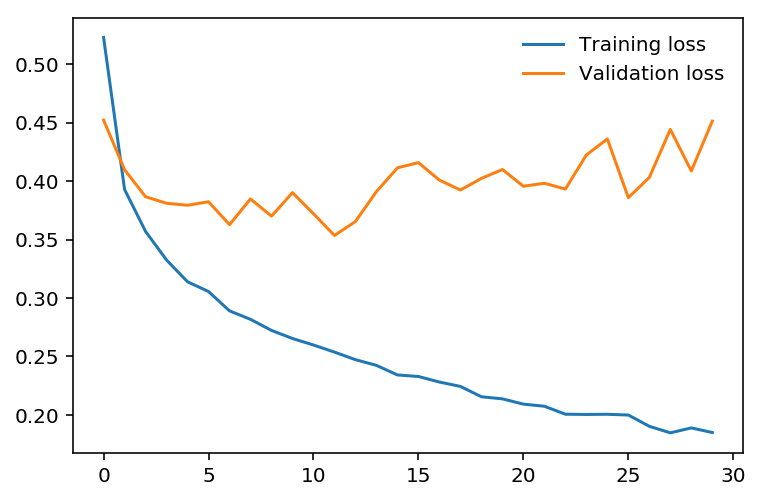

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [14]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.608..  Test Loss: 0.465..  Test Accuracy: 0.833
Epoch: 2/30..  Training Loss: 0.487..  Test Loss: 0.432..  Test Accuracy: 0.846
Epoch: 3/30..  Training Loss: 0.454..  Test Loss: 0.441..  Test Accuracy: 0.840
Epoch: 4/30..  Training Loss: 0.435..  Test Loss: 0.426..  Test Accuracy: 0.849
Epoch: 5/30..  Training Loss: 0.426..  Test Loss: 0.415..  Test Accuracy: 0.851
Epoch: 6/30..  Training Loss: 0.417..  Test Loss: 0.441..  Test Accuracy: 0.842
Epoch: 7/30..  Training Loss: 0.404..  Test Loss: 0.404..  Test Accuracy: 0.861
Epoch: 8/30..  Training Loss: 0.395..  Test Loss: 0.393..  Test Accuracy: 0.857
Epoch: 9/30..  Training Loss: 0.392..  Test Loss: 0.396..  Test Accuracy: 0.866
Epoch: 10/30..  Training Loss: 0.394..  Test Loss: 0.387..  Test Accuracy: 0.863
Epoch: 11/30..  Training Loss: 0.393..  Test Loss: 0.392..  Test Accuracy: 0.860
Epoch: 12/30..  Training Loss: 0.378..  Test Loss: 0.391..  Test Accuracy: 0.862
Epoch: 13/30..  Training Loss: 0.374.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

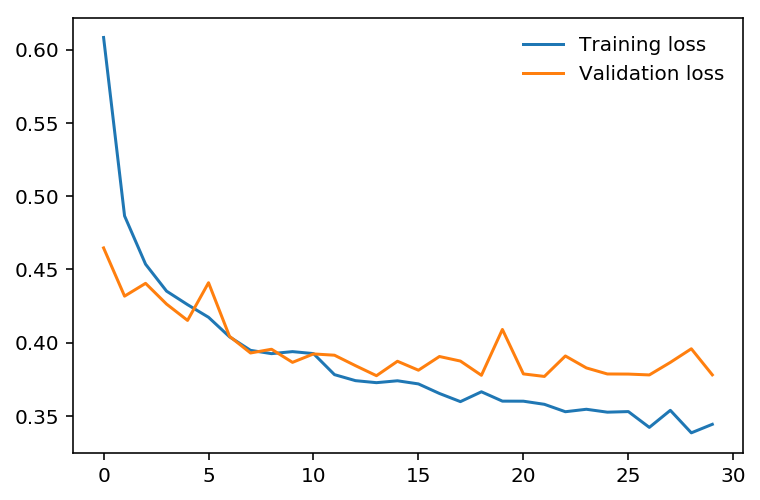

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

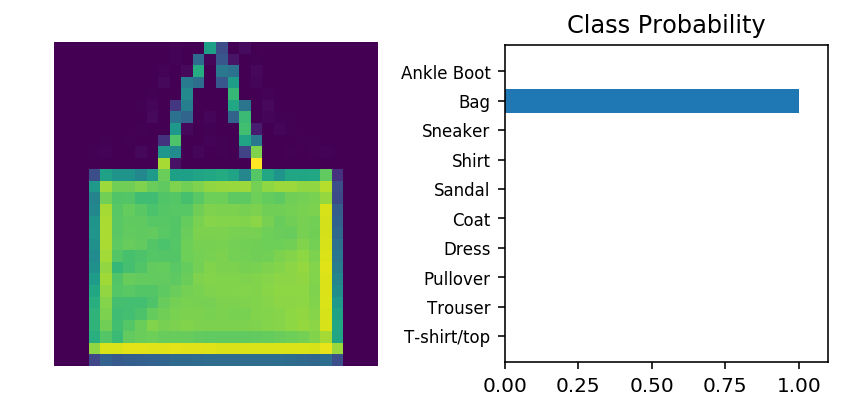

In [17]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')